![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from datetime import datetime
from sklearn.preprocessing import minmax_scale
import ast

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Пользовательские функции

In [4]:
def listfstr(s):
    """Функция для преобразования строки, представляющей собой список, в тип 'список'"""
    try:
        res = ast.literal_eval(s)
    except:
        res = []
    finally:
        return res
    
def find_item(cell):
    """Функция для проверки вхождения значения в ячейку cell
    """
    return 1 if item in cell else 0

def price_lable_encoding(p):
    """Функция для проверки вхождения значения в ячейку cell
    """
    if p == '$':
        return 1
    elif p== '$$ - $$$':
        return 2
    elif p== '$$$$':
        return 3
    else:
        return 0

# DATA

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [8]:
# создаем признак отсутствия данных по всем неполным столбцам
# upd! Price_Range_isNAN - коррелирует с другим признаком, поэтому - без него.
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')

# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

## 2. Обработка признаков

In [9]:
# Ищем претендентов на категориальные признаки
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
Cuisine_Style_isNAN            2
dtype: int64

In [10]:
### Нормируем ранг ресторана в группировке по городам
data['Ranking_Norm'] = data.groupby('City').Ranking.transform(lambda x: minmax_scale(x.astype(float)))


### перекодируем исходный "Price Range" числами 1,2,3 (по возрастанию категории цены)
data['Price_encoded'] = data['Price Range'].apply(price_lable_encoding)


# ### dummies вместо "Price Range"
# data = pd.get_dummies(data, columns=[ 'Price Range',], dummy_na=True)


### dummies вместо "City"
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)


### dummies вместо "Cuisine Style"
data['Cuisine_Style_list'] = data['Cuisine Style'].apply(listfstr)

# перебираем все рестораны, составляя set всех кухонь
cuisines = set() 
for cuisine_list in data['Cuisine_Style_list']:  
    for с in cuisine_list:
        cuisines.add(с)
        
# формируем dummies, описывающий набор кухонь для каждого ресторана
for item in cuisines:
    data[item] = data['Cuisine_Style_list'].apply(find_item)
    
# доп. признак: количество разных стилей кухонь, указанных в ресторане.
data['Cuisine_style_cnt'] = data['Cuisine_Style_list'].apply(len)


### Сколько дней назад был оставлен последний отзыв
data["Reviews"] = data["Reviews"].str.replace("nan", "' '")
data["Reviews"].fillna("[[], []]", inplace=True)

# вычленяем из текста даты
data["Reviews_list"] = data["Reviews"].apply(listfstr)
data["Reviews Dates"] = data["Reviews_list"].apply(lambda x: [datetime.strptime(d, "%m/%d/%Y") for d in x[1]])

# рассчитываем, как давно был оставлен последний отзыв
data["Review_Days_Ago"] = data["Reviews Dates"].apply(
 lambda x: (datetime.today() - max(x)).days if len(x) >= 1 else -1
)

In [11]:
# Удаляем лишние признаки
data = data.drop(['Cuisine Style','Cuisine_Style_list','Reviews',
                  'Reviews Dates','Reviews_list','URL_TA','ID_TA', 
                  'Ranking', 'Price Range'], axis = 1)

# # Переименуем колонки для удобства
# data.rename(columns={'Price Range_$': 'Price_Range_1', 'Price Range_$$ - $$$': 'Price_Range_2',
#                      'Price Range_$$$$': 'Price_Range_3'}, inplace=True)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

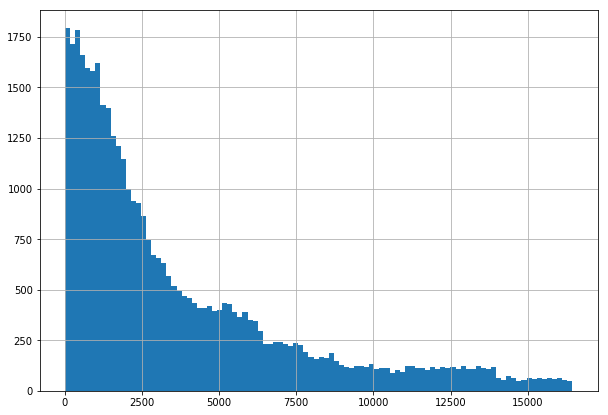

In [12]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

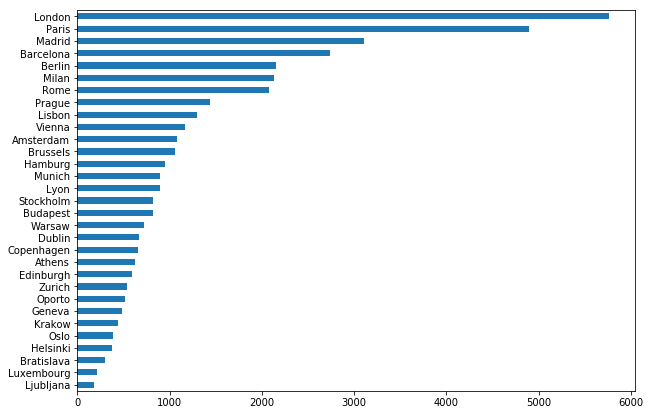

In [13]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

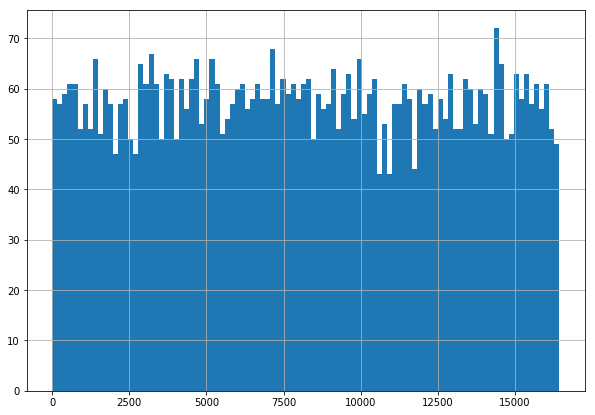

In [14]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

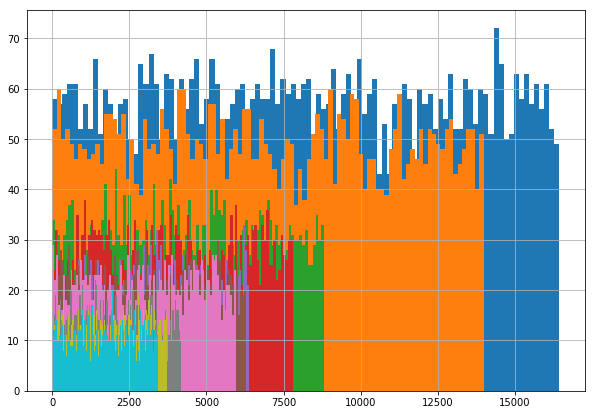

In [15]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

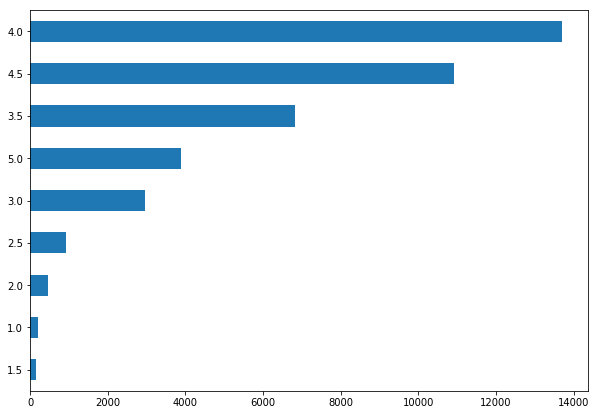

In [16]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно нового признака Ranking_Norm

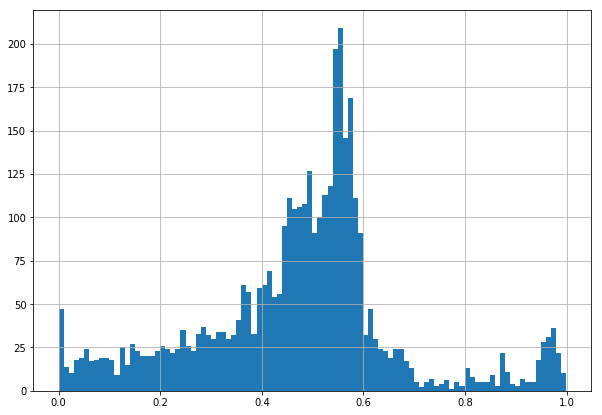

In [17]:
data['Ranking_Norm'][data['Rating'] == 5].hist(bins=100)

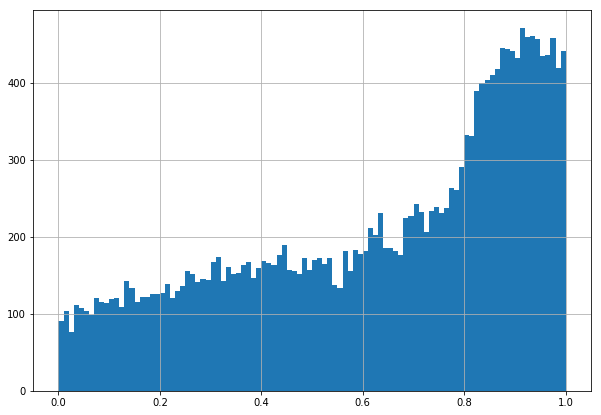

In [18]:
data['Ranking_Norm'][data['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков]
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [19]:
data_no_dummies = data[['Number of Reviews',
'Rating',
'Number_of_Reviews_isNAN',
'Cuisine_Style_isNAN',
'Ranking_Norm',
'Price_encoded',
'Review_Days_Ago',
'Cuisine_style_cnt']]

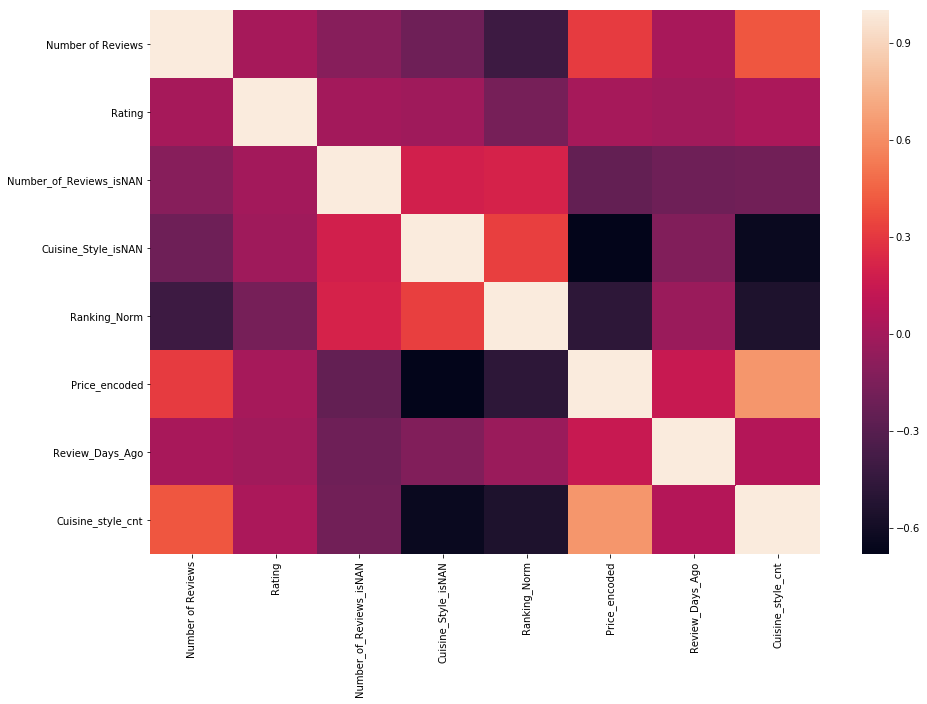

In [20]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data_no_dummies.corr(),)

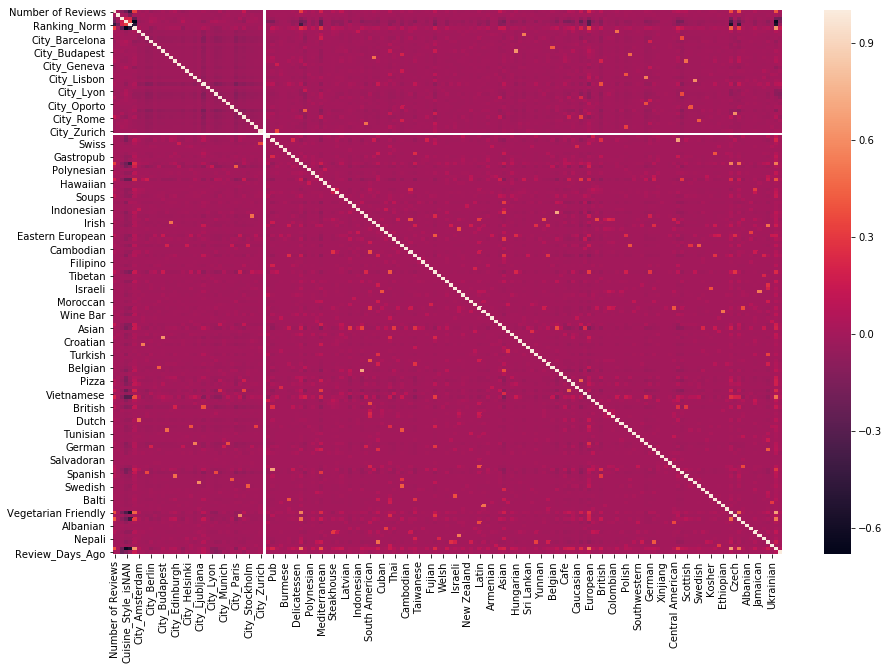

In [21]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [22]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [23]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor df_output.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA','URL_TA',], axis = 1, inplace=True)
    
    # ################### 2. NAN ############################################################## 
    
    # создаем признак отсутствия данных по всем неполным столбцам
    # upd! Price_Range_isNAN - коррелирует с другим признаком, поэтому - без него.
    df_output['Number_of_Reviews_isNAN'] = pd.isna(df_output['Number of Reviews']).astype('uint8')
    df_output['Cuisine_Style_isNAN'] = pd.isna(df_output['Cuisine Style']).astype('uint8')

    # Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    
    
    # ################### 3. Encoding ############################################################## 

    ### Нормируем ранг ресторана в группировке по городам
    df_output['Ranking_Norm'] = df_output.groupby('City').Ranking.transform(lambda x: minmax_scale(x.astype(float)))

    ### перекодируем исходный "Price Range" числами 1,2,3 (по возрастанию категории цены)
    df_output['Price_encoded'] = df_output['Price Range'].apply(price_lable_encoding)

    ### dummies вместо "City"
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)

    ### dummies вместо "Cuisine Style"
    df_output['Cuisine_Style_list'] = df_output['Cuisine Style'].apply(listfstr)
    
    # перебираем все рестораны, составляя set всех кухонь
    cuisines = set() 
    for cuisine_list in df_output['Cuisine_Style_list']:  
        for с in cuisine_list:
            cuisines.add(с)
    # формируем dummies, описывающий набор кухонь для каждого ресторана
    for item in cuisines:
        df_output[item] = df_output['Cuisine_Style_list'].apply(find_item)
        
        
    # ################### 4. Feature Engineering ####################################################

    # доп. признак: количество разных стилей кухонь, указанных в ресторане.
    df_output['Cuisine_style_cnt'] = df_output['Cuisine_Style_list'].apply(len)
    
    ### Сколько дней назад был оставлен последний отзыв
    df_output["Reviews"] = df_output["Reviews"].str.replace("nan", "' '")
    df_output["Reviews"].fillna("[[], []]", inplace=True)

    # вычленяем из текста даты
    df_output["Reviews_list"] = df_output["Reviews"].apply(listfstr)
    df_output["Reviews Dates"] = df_output["Reviews_list"].apply(lambda x: [datetime.strptime(d, "%m/%d/%Y") for d in x[1]])

    # рассчитываем, как давно был оставлен последний отзыв
    df_output["Review_Days_Ago"] = df_output["Reviews Dates"].apply(
     lambda x: (datetime.today() - max(x)).days if len(x) >= 1 else -1
    )
    
    
    # ################### 5. Clean #################################################### 
    # убираем служебные признаки
    df_output = df_output.drop(['Cuisine Style','Cuisine_Style_list','Reviews',
                  'Reviews Dates','Reviews_list', 'Ranking', 'Price Range'], axis = 1)
    
    
    # модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

#### Запускаем и проверяем что получилось

In [24]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Ranking_Norm,Price_encoded,City_Amsterdam,City_Athens,City_Barcelona,...,Mexican,Albanian,Singaporean,Barbecue,Jamaican,Nepali,Middle Eastern,Ukrainian,Cuisine_style_cnt,Review_Days_Ago
23557,5.0,1,5.0,0,0,0.528213,2,0,0,0,...,0,0,0,0,0,0,0,0,1,-1
11979,0.0,1,1.0,1,0,0.997712,0,0,0,0,...,0,0,0,0,0,0,0,0,2,-1
37918,100.0,1,4.0,0,0,0.243485,2,0,0,0,...,0,0,0,0,0,0,0,0,5,1126
40120,41.0,1,4.0,0,0,0.704052,2,0,0,0,...,0,0,0,0,0,0,0,0,3,1227
14488,0.0,1,5.0,1,0,0.572052,2,0,0,0,...,0,0,0,0,0,0,0,0,3,-1
13778,17.0,1,3.0,0,1,0.696866,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
20264,6.0,1,4.5,0,1,0.495173,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
41883,625.0,1,4.0,0,0,0.067313,3,0,0,0,...,0,0,0,0,0,0,0,0,6,1084
2337,51.0,0,0.0,0,0,0.826066,2,0,0,0,...,0,0,0,0,0,0,0,0,2,1244
44626,550.0,1,5.0,0,0,0.000000,1,0,0,0,...,0,0,0,0,0,0,0,0,8,1027


In [25]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 166 entries, Number of Reviews to Review_Days_Ago
dtypes: float64(3), int64(129), uint8(34)
memory usage: 52.0 MB


In [26]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [27]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [28]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 165), (40000, 165), (40000, 164), (32000, 164), (8000, 164))

# Model 
Сам ML

In [29]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [30]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [31]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [32]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20342


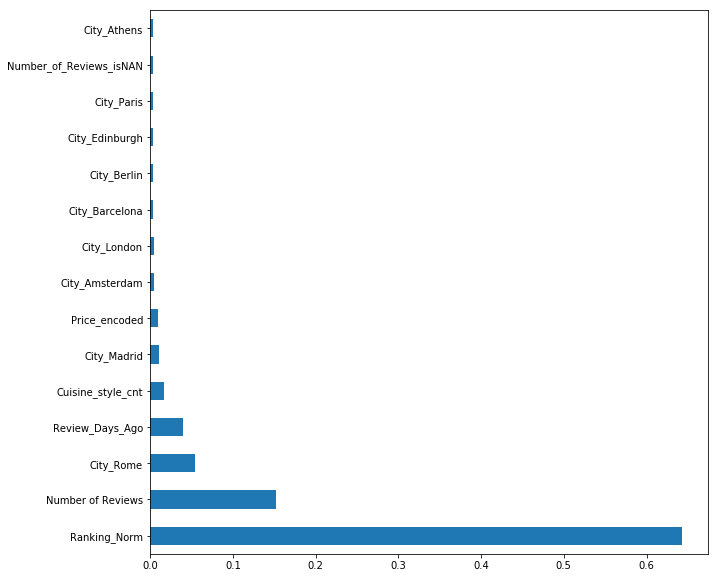

In [33]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [34]:
test_data.sample(10)

,Number of Reviews,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Ranking_Norm,Price_encoded,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,...,Mexican,Albanian,Singaporean,Barbecue,Jamaican,Nepali,Middle Eastern,Ukrainian,Cuisine_style_cnt,Review_Days_Ago
9300,9.0,0.0,0,0,0.586683,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2372
7562,3.0,0.0,0,0,0.955435,2,0,0,0,0,...,0,0,0,0,0,0,0,0,3,-1
5927,19.0,0.0,0,0,0.458736,2,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1247
6517,0.0,0.0,1,1,0.686155,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2643
9711,18.0,0.0,0,0,0.445390,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1441
4868,47.0,0.0,0,0,0.544426,2,0,0,0,0,...,0,0,0,0,0,0,0,0,4,1071
5162,24.0,0.0,0,0,0.467676,2,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1072
536,17.0,0.0,0,1,0.644584,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1223
3903,6.0,0.0,0,0,0.565058,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1538
8488,477.0,0.0,0,0,0.268275,2,0,0,0,0,...,0,0,0,0,0,0,0,0,4,1034


In [35]:
test_data = test_data.drop(['Rating'], axis=1)

In [36]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [37]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [38]:
predict_submission

array([3.15 , 4.275, 4.44 , ..., 3.15 , 4.5  , 4.41 ])

In [39]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.150
1,id_1,4.275
2,id_2,4.440
3,id_3,4.305
4,id_4,4.505
5,id_5,4.510
6,id_6,1.130
7,id_7,3.450
8,id_8,4.205
9,id_9,4.710


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
